In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum
from timescales.sim import sim_spikes_synaptic
from timescales.fit.psd import fit_psd, convert_knee_val
from timescales.fit.acf import fit_acf, compute_acf

### Spectral Estimation Comparisons

This notebook compares how different spectral estimation methods (welch vs medfilt vs wavelets) compare. A large tau is simulated, which is known to result in poor estimates via welch's method.

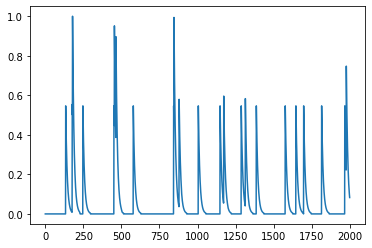

In [2]:
n_seconds = 2
fs = 1000

tau = .01
n_neurons = 1
mu = 100

probs = np.zeros((100, int(fs * n_seconds)))

for i in range(100):
    _probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=n_neurons)
    probs[i] = _probs
    
plt.plot(probs[0]);

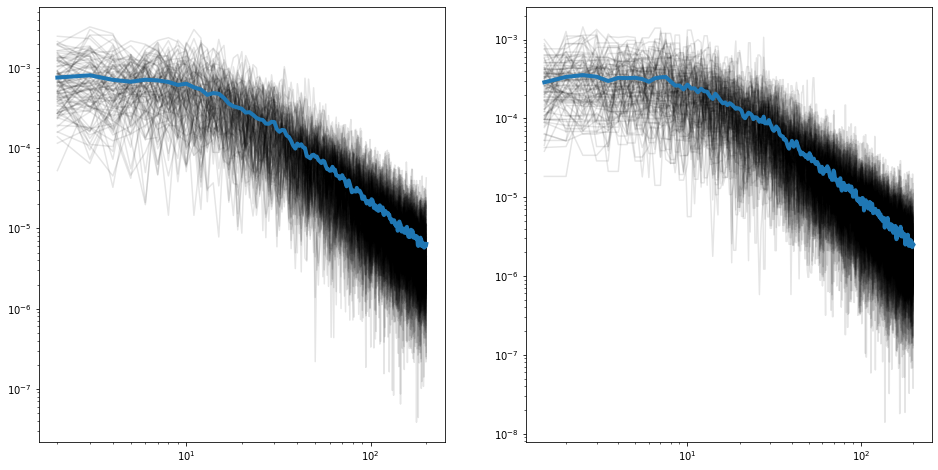

In [3]:
f_range = (1, 200)

freqs_welch, powers_welch = compute_spectrum(probs, fs, method='welch', f_range=f_range)

freqs_med, powers_med = compute_spectrum(probs, fs, method='medfilt', filt_len=1, f_range=f_range)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

for p in powers_welch:
    axes[0].loglog(freqs_welch[1:], p[1:], color='k', alpha=.1)
for p in powers_med:
    axes[1].loglog(freqs_med[1:], p[1:], color='k', alpha=.1)
    
    
axes[0].loglog(freqs_welch[1:], powers_welch.mean(axis=0)[1:], label='Welch', lw=4)
axes[1].loglog(freqs_med[1:], powers_med.mean(axis=0)[1:], label='MedFilt', lw=4);

In [4]:
# Fit fooof
fooof_init = {'max_n_peaks': 0}

fg_welch, kf_welch, kt_welch = fit_psd(freqs_welch, powers_welch, f_range=f_range,
                                       fooof_init=fooof_init, knee_bounds=(.5, 1000))

fg_med, kf_med, kt_med = fit_psd(freqs_med, powers_med, f_range=f_range,
                                 fooof_init=fooof_init, knee_bounds=(.5, 1000))


# Fit ACF
corrs = compute_acf(probs, len(probs[0]))
params, _, _ = fit_acf(corrs, fs)

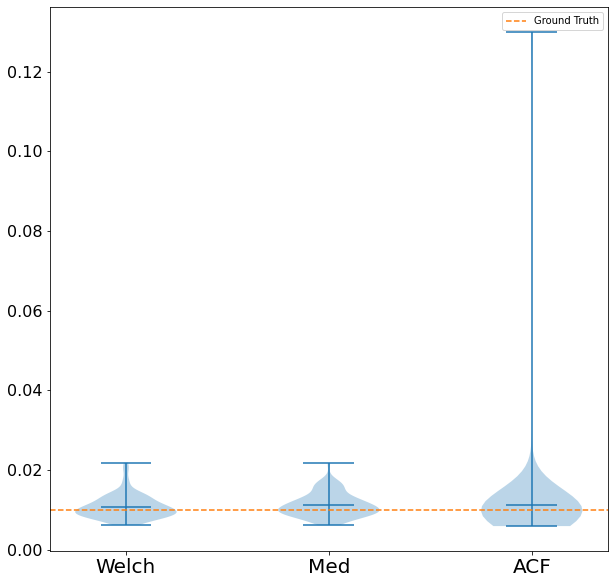

In [5]:
# Plot fooof
plt.figure(figsize=(10, 10))

plt.violinplot([kt_welch, kt_med, params[:, 0]], showmeans=True)
plt.axhline(tau, color='C1', ls='dashed', label='Ground Truth')

plt.yticks(size=16)
plt.xticks([1, 2, 3], ['Welch', 'Med', 'ACF'], size=20)

plt.legend();